In [1]:
%pylab inline

from PyTools import err, binner, nbins
from sklearn.cluster import DBSCAN
from string import join
import pyfits as pyf
from scipy.ndimage.filters import gaussian_filter
import pres_style, os

Populating the interactive namespace from numpy and matplotlib


/home/chapi/mejia/Programs/miniconda/envs/phd/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
def put_FITS_names(table):
    descr = table.dtype.descr
    for i in xrange(3): descr.pop(0)
    descr = [("input_file", "|S25")] + descr

    new_table = zeros(table.shape[0], dtype=descr)
    new_table["input_file"] = ["spSpec-{0:05d}-{1:04d}-{2:03d}.fit".format(r["mjd"], r["plate"], r["fiberID"]) for r in table]
    for f in new_table.dtype.names[1:]:
        new_table[f] = table[f]
    
    return new_table

par_lbs = [r"$M_\star$", r"$\left<\log{t_\star}\right>_M$", r"$\left<\log{t_\star}\right>_L$",
           r"$\left<\log{Z_\star/Z\odot}\right>_M$", r"$\left<\log{Z_\star/Z\odot}\right>_L$", r"$A_V$"]

if "paper_style" in dir():
    od = os.path.expandvars("$HOME/Documents/Papers/photofit_near_paper/")
    par_lbs = [r"$M_\star$", r"$\left<\log{t_\star}\right>_M$", r"$\left<\log{t_\star}\right>_L$",
               r"$\left<\log{Z_\star/Z\odot}\right>_M$", r"$\left<\log{Z_\star/Z\odot}\right>_L$", r"$A_V$",
               r"$A_V$", r"$z$"]
    res_lbs = [r"$\Delta\log{M_\star}$", r"$\Delta\left<\log{t_\star}\right>_M$", r"$\Delta\left<\log{t_\star}\right>_L$",
               r"$\Delta\left<\log{Z_\star}\right>_M$", r"$\Delta\left<\log{Z_\star}\right>_L$", r"$\Delta A_V$"]
else:
    od = ""
    par_lbs = ["Mass (M$\odot$)", "Age (log/yr)", "Age (log/yr)", "Metallicity (log/Z$\odot$)",
               "Metallicity (log/Z$\odot$)", "Dust Extinction (mag)", "Redshift"]

In [23]:
#READ TABLES

catalog = genfromtxt("catalog.txt", dtype=None, names=True)
spec_ne = genfromtxt("spec_ne.txt", dtype=None, names=True)
jpas_ye = genfromtxt("jpas_ye.txt", dtype=None, names=True)
jpas_ne = genfromtxt("jpas_ne.txt", dtype=None, names=True)
jpas_me = genfromtxt("jpas_me.txt", dtype=None, names=True)
gal2005 = genfromtxt("gal2005.txt", dtype=None, names=True)
galtab2 = array([[ 8.91, -0.60, -1.11, -0.00, 9.06, 8.80,  9.46],
                 [ 9.11, -0.61, -1.07, -0.00, 9.09, 8.81,  9.48],
                 [ 9.31, -0.65, -1.10, -0.05, 9.11, 8.85,  9.44],
                 [ 9.51, -0.61, -1.03, -0.01, 9.17, 8.89,  9.49],
                 [ 9.72, -0.52, -0.97,  0.05, 9.23, 8.94,  9.57],
                 [ 9.91, -0.41, -0.90,  0.09, 9.32, 9.00,  9.71],
                 [10.11, -0.23, -0.80,  0.14, 9.46, 9.09,  9.85],
                 [10.31, -0.11, -0.65,  0.17, 9.61, 9.23,  9.93],
                 [10.51, -0.01, -0.41,  0.20, 9.73, 9.34,  9.98],
                 [10.72,  0.04, -0.24,  0.22, 9.82, 9.48, 10.03],
                 [10.91,  0.07, -0.14,  0.24, 9.87, 9.60, 10.06],
                 [11.11,  0.10, -0.09,  0.25, 9.90, 9.67, 10.08],
                 [11.31,  0.12, -0.06,  0.26, 9.92, 9.72, 10.09],
                 [11.51,  0.13, -0.04,  0.28, 9.94, 9.75, 10.11],
                 [11.72,  0.14, -0.03,  0.29, 9.95, 9.76, 10.12],
                 [11.91,  0.15, -0.03,  0.30, 9.96, 9.77, 10.12]])
Lfrac = put_FITS_names(genfromtxt("lumfrac.txt", dtype=None, names=True))
SN = genfromtxt("snr.txt")
Cind = put_FITS_names(genfromtxt("conIndex_test.txt", dtype=None, names=True))

In [24]:
#COMMON QUANTITIES

lcolor = catalog["u_mag"] - catalog["r_mag"]
rfract = 10**(-0.4*Lfrac["fiberMag_r"])/10**(-0.4*Lfrac["modelMag_r"])
C = Cind["petroR90_r"]/Cind["petroR50_r"]

bmask = lcolor < 2.22
rmask = ~bmask
nmask = array([n in jpas_ne["input_file"] for n in jpas_me["input_file"]], dtype=bool)
gmask = ones(catalog.size, dtype=np.bool)#array([n in gal2005["input_file"] for n in catalog["input_file"]], dtype=bool)

/home/chapi/mejia/Programs/miniconda/envs/phd/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in divide


In [165]:
zmask = (spec_ne[gmask]["log_Z_L_mod"]>log10(0.004/0.02))&(~isnan(C))&(catalog["redshift"]>=0.05)#&(gal2005["z_mode"]>log10(0.004/0.02))#&(SN[gmask]>20.)&(catalog[gmask]["redshift"]>0.05)
sfgal = lcolor[gmask][zmask]<2.22
pagal = lcolor[gmask][zmask]>2.22

s = spec_ne[gmask][zmask]
#g = gal2005[zmask]
cat = catalog[gmask][zmask]
rat = 3./Cind["petroR90_r"][gmask][zmask]
col = lcolor[gmask][zmask]
con = C[gmask][zmask]

X = zeros((s.size, 2))
X[:, 0], X[:, 1] = s["log_t_L_mod"], s["log_Z_L_mod"]

print "tables match? ", all((s["input_file"]==cat["input_file"])&(s["input_file"]==Cind["input_file"][gmask][zmask]))
print "table sizes: ", con.size

tables match?  True
table sizes:  19501


In [185]:
db = DBSCAN(eps=0.04, min_samples=50).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

print unique(labels)

#labels[labels>=3] = -1

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
unique_labels = set(labels)
c1m = labels==0
c2m = labels==1
noi = labels==-1
#colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))
colors = ["#114477", "#117733", "#771122"]

[-1  0  1]


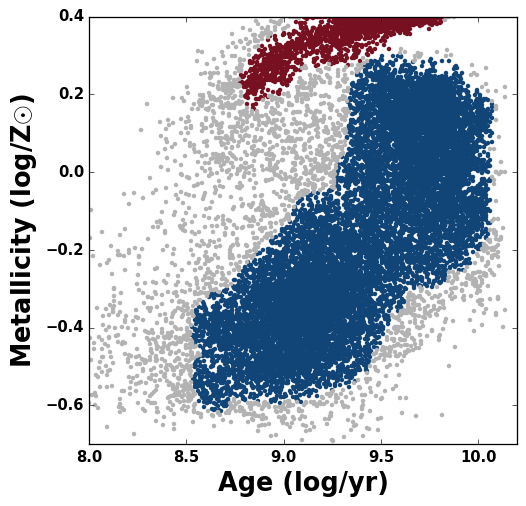

In [186]:
xlim(8.0, 10.2)
ylim(-0.7, 0.4)
xlabel(par_lbs[2])
ylabel(par_lbs[4])

mask = (cat["redshift"]>0.05)

plot(X[mask&c1m, 0], X[mask&c1m, 1], ".", color=colors[0])
plot(X[mask&c2m, 0], X[mask&c2m, 1], ".", color=colors[2])
plot(X[mask&noi, 0], X[mask&noi, 1], ".", color="0.7")

savefig("age_met_scatter")

In [187]:
print (c2m.sum()*100.)/c1m.sum()

13.9143730887


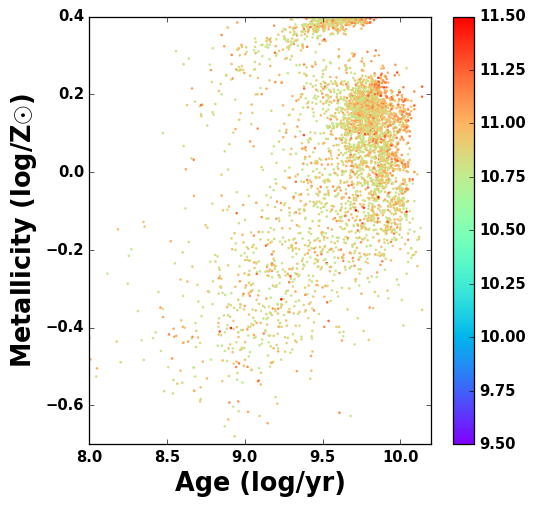

In [188]:
xlim(8.0, 10.2)
ylim(-0.7, 0.4)
xlabel(par_lbs[2])
ylabel(par_lbs[4])

mask = (s["M_mod"]>10.75)&(s["M_mod"]<100.)

scatter(X[mask, 0], X[mask, 1], c=s["M_mod"][mask], s=4, vmin=9.5, vmax=11.5, cmap=cm.rainbow)
cb = colorbar()
cb.set_label('')

#savefig("age_met_scatter")

<a list of 9 text.Text objects>

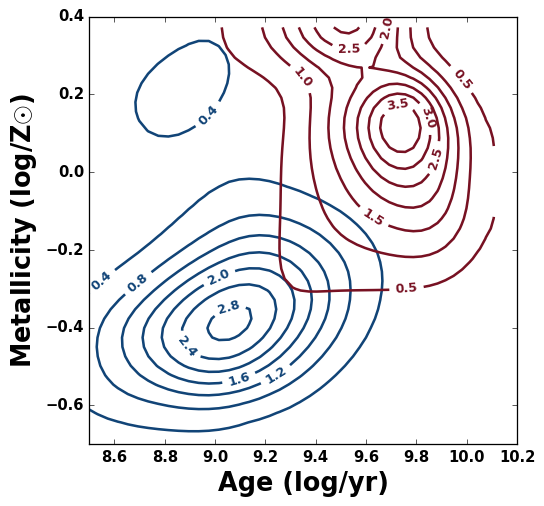

In [189]:
xlim(8.5, 10.2)
ylim(-0.7, 0.4)
xlabel(par_lbs[2])
ylabel(par_lbs[4])

mask = (cat["redshift"][:]>0.0)&(sfgal[:])
nx, xi, xf, bsx = nbins(X[:, 0][mask])
ny, yi, yf, bsy = nbins(X[:, 1][mask])

H, xe, ye = histogram2d(X[:, 0][mask], X[:, 1][mask], bins=(nx, ny), normed=True)
H = gaussian_filter(H, sigma=3)

cont = contour(xe[:- 1], ye[:- 1], H.T, colors=colors[0])
clabel(cont, fontsize=10, fmt=r"%.1f", inline=True)

mask = (cat["redshift"][:]>0.0)&(pagal[:])
nx, xi, xf, bsx = nbins(X[:, 0][mask])
ny, yi, yf, bsy = nbins(X[:, 1][mask])

H, xe, ye = histogram2d(X[:, 0][mask], X[:, 1][mask], bins=(nx, ny), normed=True)
H = gaussian_filter(H, sigma=3)

cont = contour(xe[:- 1], ye[:- 1], H.T, colors=colors[2])
clabel(cont, fontsize=10, fmt=r"%.1f", inline=True)

#savefig(od + "age_met.pdf")

<a list of 7 text.Text objects>

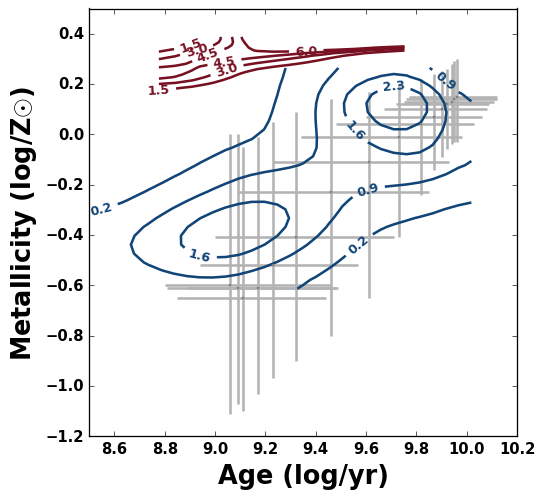

In [190]:
xlim(8.5, 10.2)
ylim(-1.2, 0.5)
xlabel(par_lbs[2])
ylabel(par_lbs[4])

errorbar(galtab2[:, 4], galtab2[:, 1], xerr=[abs(galtab2[:, 4]-galtab2[:, 5]), abs(galtab2[:, 4]-galtab2[:, 6])],
        yerr=[abs(galtab2[:, 1]-galtab2[:, 2]), abs(galtab2[:, 1]-galtab2[:, 3])], fmt="o", color="0.5",
         ecolor="0.7", ms=2, capsize=0)

#CONTOURS FOR CLUSTER #1
mask = (s["M_mod"][c1m]<14.)
nx, xi, xf, bsx = nbins(X[c1m, 0][mask])
ny, yi, yf, bsy = nbins(X[c1m, 1][mask])

H, xe, ye = histogram2d(X[c1m, 0][mask], X[c1m, 1][mask], bins=(nx, ny), normed=True)
H = gaussian_filter(H, sigma=2)

cont = contour(xe[:- 1], ye[:- 1], H.T, colors=colors[0], levels=np.arange(0.2, 14, 0.7))
clabel(cont, fontsize=10, fmt=r"%.1f", inline=True)

#CONTOURS FOR CLUSTER #2
mask = (s["M_mod"][c2m]<14.)
nx, xi, xf, bsx = nbins(X[c2m, 0][mask])
ny, yi, yf, bsy = nbins(X[c2m, 1][mask])

H, xe, ye = histogram2d(X[c2m, 0][mask], X[c2m, 1][mask], bins=(nx, ny), normed=True)
H = gaussian_filter(H, sigma=2)

cont = contour(xe[:- 1], ye[:- 1], H.T, colors=colors[2], levels=np.arange(1.5, 7, 1.5))
clabel(cont, fontsize=10, fmt=r"%.1f", inline=True)

#savefig(od + "age_met.pdf")

[      nan       nan       nan  0.66325   0.6617    0.6816    0.651
  0.420715  0.30235   0.34979 ]
[        nan         nan         nan  0.12918933  0.21167803  0.23704141
  0.22444699  0.20402554  0.1771177   0.29141518]
[  nan   nan   nan  0.02  0.04 -0.04 -0.2  -0.2  -0.04 -0.04]


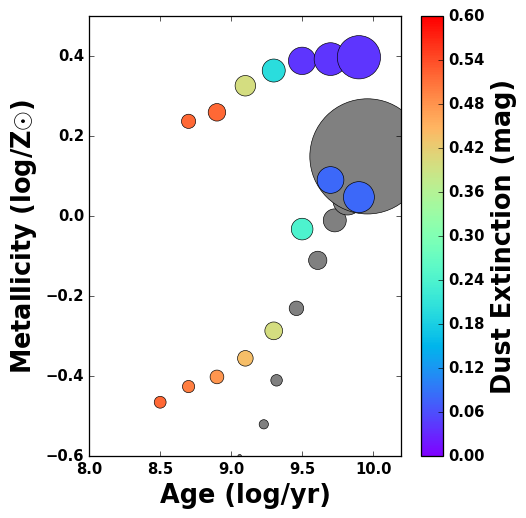

In [191]:
xlim(8.0, 10.2)
ylim(-0.6, 0.5)
xlabel(par_lbs[2])
ylabel(par_lbs[4])

scatter(galtab2[:, 4], galtab2[:, 1], s=10**galtab2[:, 0]/1e8, c="0.5", marker="o", lw=0.5)

t, z = binner(s["log_t_L_mod"][c1m], s["log_Z_L_mod"][c1m], "median", 10, [8., 10.])
t, m = binner(s["log_t_L_mod"][c1m], s["M_mod"][c1m], "median", 10, [8., 10.])
t, d = binner(s["log_t_L_mod"][c1m], s["Av_mod"][c1m], "median", 10, [8., 10.])
scatter(t, z, s=10**m/1e8, c=d, cmap=cm.rainbow, vmin=0.0, vmax=0.6, marker="o", lw=0.5)

z1, m1, d1 = z, m, d

t, z = binner(s["log_t_L_mod"][c2m], s["log_Z_L_mod"][c2m], "median", 10, [8., 10.])
t, m = binner(s["log_t_L_mod"][c2m], s["M_mod"][c2m], "median", 10, [8., 10.])
t, d = binner(s["log_t_L_mod"][c2m], s["Av_mod"][c2m], "median", 10, [8., 10.])
scatter(t, z, s=10**m/1e8, c=d, cmap=cm.rainbow, vmin=0.0, vmax=0.6, marker="o", lw=0.5)

z2, m2, d2 = z, m, d

print z2-z1
print m2-m1
print d2-d1

cb = colorbar()
cb.set_label(par_lbs[-2])
tight_layout()
savefig(od + "age_met_ext.pdf")

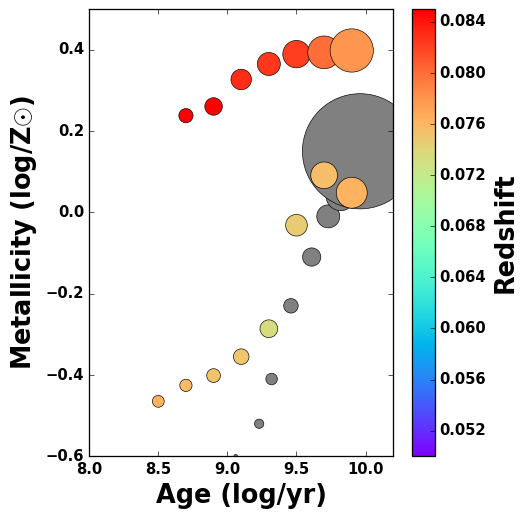

In [200]:
xlim(8.0, 10.2)
ylim(-0.6, 0.5)
xlabel(par_lbs[2])
ylabel(par_lbs[4])

scatter(galtab2[:, 4], galtab2[:, 1], s=10**galtab2[:, 0]/1e8, c="0.5", marker="o", lw=0.5)

t, z = binner(s["log_t_L_mod"][c1m], s["log_Z_L_mod"][c1m], "median", 10, [8., 10.])
t, m = binner(s["log_t_L_mod"][c1m], s["M_mod"][c1m], "median", 10, [8., 10.])
t, d = binner(s["log_t_L_mod"][c1m], cat["redshift"][c1m], "median", 10, [8., 10.])
scatter(t, z, s=10**m/1e8, c=d, cmap=cm.rainbow, vmin=0.05, vmax=0.085, marker="o", lw=0.5)

t, z = binner(s["log_t_L_mod"][c2m], s["log_Z_L_mod"][c2m], "median", 10, [8., 10.])
t, m = binner(s["log_t_L_mod"][c2m], s["M_mod"][c2m], "median", 10, [8., 10.])
t, d = binner(s["log_t_L_mod"][c2m], cat["redshift"][c2m], "median", 10, [8., 10.])
scatter(t, z, s=10**m/1e8, c=d, cmap=cm.rainbow, vmin=0.05, vmax=0.085, marker="o", lw=0.5)

cb = colorbar()
cb.set_label(r"Redshift")

tight_layout()
savefig(od + "age_met_red.pdf")

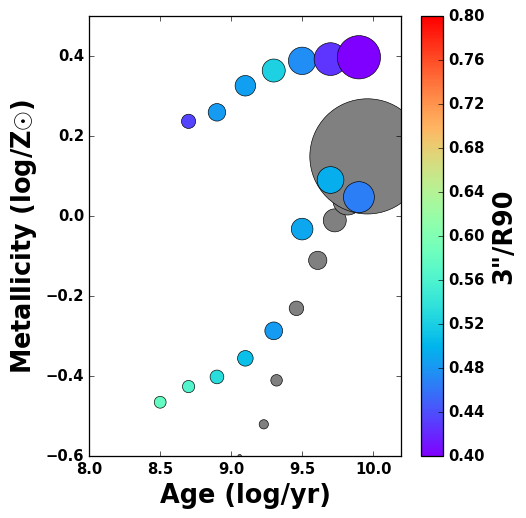

In [193]:
xlim(8.0, 10.2)
ylim(-0.6, 0.5)
xlabel(par_lbs[2])
ylabel(par_lbs[4])

scatter(galtab2[:, 4], galtab2[:, 1], s=10**galtab2[:, 0]/1e8, c="0.5", marker="o", lw=0.5)

t, z = binner(s["log_t_L_mod"][c1m], s["log_Z_L_mod"][c1m], "median", 10, [8., 10.])
t, m = binner(s["log_t_L_mod"][c1m], s["M_mod"][c1m], "median", 10, [8., 10.])
t, d = binner(s["log_t_L_mod"][c1m], rat[c1m], "median", 10, [8., 10.])
scatter(t, z, s=10**m/1e8, c=d, cmap=cm.rainbow, vmin=0.4, vmax=0.8, marker="o", lw=0.5)

t, z = binner(s["log_t_L_mod"][c2m], s["log_Z_L_mod"][c2m], "median", 10, [8., 10.])
t, m = binner(s["log_t_L_mod"][c2m], s["M_mod"][c2m], "median", 10, [8., 10.])
t, d = binner(s["log_t_L_mod"][c2m], rat[c2m], "median", 10, [8., 10.])
scatter(t, z, s=10**m/1e8, c=d, cmap=cm.rainbow, vmin=0.4, vmax=0.8, marker="o", lw=0.5)

cb = colorbar()
cb.set_label(r'3"/R90')

tight_layout()
savefig(od + "age_met_fra.pdf")

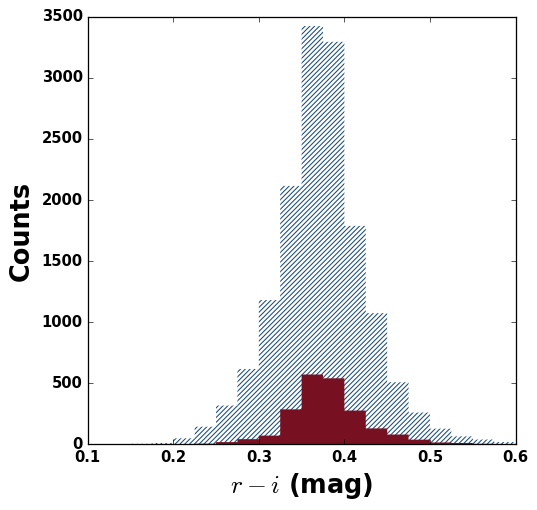

In [194]:
hist((cat["r_mag"]-cat["i_mag"])[c1m], 20, range=(0.1, 0.6), histtype="step", hatch="/////", lw=0, color=colors[0])
hist((cat["r_mag"]-cat["i_mag"])[c2m], 20, range=(0.1, 0.6), histtype="stepfilled", lw=0, color=colors[2])
xlabel(r"$r-i$ (mag)")
ylabel(r"Counts")
#savefig("r-i.png", bbox_inches="tight")

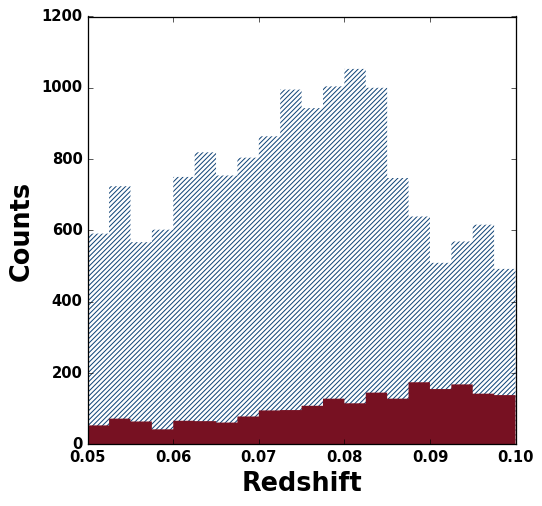

In [201]:
hist(cat["redshift"][c1m], 20, range=(0.05, 0.1), histtype="step", hatch="/////", lw=0, color=colors[0])
hist(cat["redshift"][c2m], 20, range=(0.05, 0.1), histtype="stepfilled", lw=0, color=colors[2])

xlabel(r"Redshift")
ylabel(r"Counts")

#savefig("redshift.png", bbox_inches="tight")

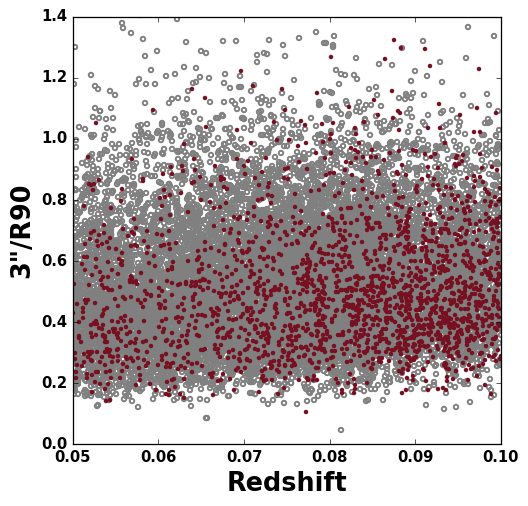

In [204]:
plot(cat["redshift"][c1m], rat[c1m], ".", mfc="none", mec="0.5", mew=1.5)
plot(cat["redshift"][c2m], rat[c2m], ".", mfc=colors[2])

xlim(0.05, 0.1)
ylim(0.0, 1.4)
xlabel(r"Redshift")
ylabel(r'3"/R90')

2093


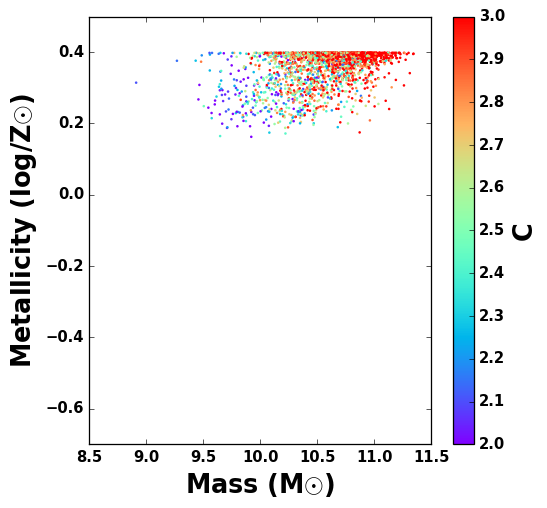

In [205]:
xlim(8.5, 11.5)
ylim(-0.7, 0.5)
xlabel(par_lbs[0])
ylabel(par_lbs[4])

mask = c2m
scatter(s["M_mod"][mask], s["log_Z_L_mod"][mask], c=con[mask], s=4, vmin=2, vmax=3., cmap=cm.rainbow)
cb = colorbar()

print mask.sum()

cb.set_label("C")

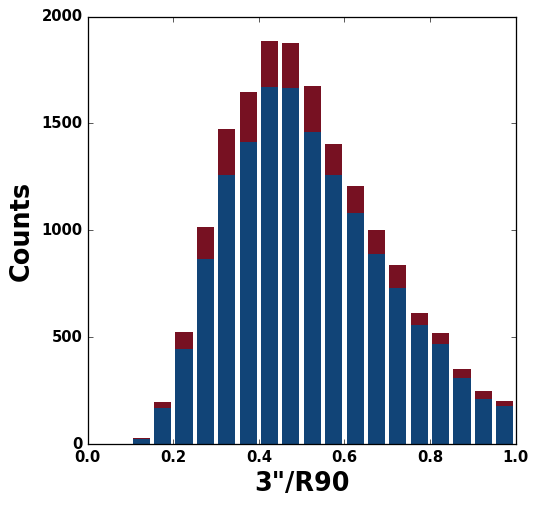

In [206]:
hist([rat[c1m], rat[c2m]], 20, range=(0., 1), histtype="barstacked", color=[colors[0], colors[2]])

xlabel('3"/R90')
ylabel("Counts")

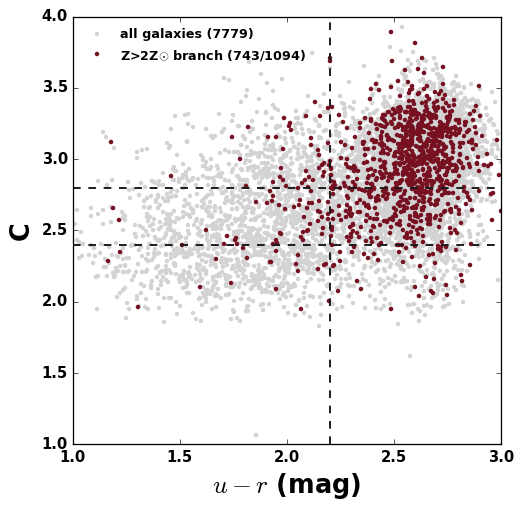

In [207]:
mask = (SN[gmask][zmask]>20.)
sm = c2m#&(s["log_Z_L_mod"]>0.39)&pagal

plot(lcolor[gmask][zmask][mask], C[gmask][zmask][mask], ".", color="lightgray", label="all galaxies (%d)"%sum(mask))
#plot(lcolor[gmask][zmask][mask&c1m], C[gmask][zmask][mask&c1m], ".", color=colors[0], label="~Z$\odot$ branch")
plot(lcolor[gmask][zmask][mask&sm], C[gmask][zmask][mask&sm], ".", color=colors[2], label="Z>2Z$\odot$ branch (%d/%d)"%(sum(C[gmask][zmask][c2m&mask]>=2.8), sum(sm&mask)))
legend(loc=2, fontsize=10)

axvline(2.2, ls="--", color="0.1", lw=1.5)
axhline(2.4, ls="--", color="0.1", lw=1.5)
axhline(2.8, ls="--", color="0.1", lw=1.5)

xlim(1, 3)
ylim(1, 4)
xlabel("$u-r$ (mag)")
ylabel("C")

In [238]:
galmask = array([i for i in xrange(gal2005["input_file"].size) if gal2005["input_file"][i] in s["input_file"][c2m]])
print galmask.size, c2m.sum()

1209 2093


(array([ 0.13108181,  0.12337112,  0.22361015,  0.34698126,  0.77878017,
         0.84046573,  1.94309507,  2.49826509,  1.28768602,  0.91757267]),
 array([-0.7 , -0.59, -0.48, -0.37, -0.26, -0.15, -0.04,  0.07,  0.18,
         0.29,  0.4 ]),
 <a list of 1 Patch objects>)

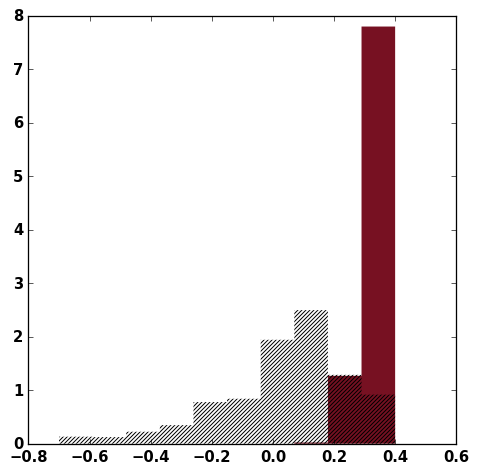

In [242]:
rang = (-0.7, 0.4)

hist(s["log_Z_L_mod"][c2m], range=rang, histtype="stepfilled", color=colors[2], normed=True)
hist(gal2005[galmask]["z_mode"], range=rang, histtype="step", hatch="//////", color="k", normed=True)

In [274]:
avneg = genfromtxt("dynbas_output.log", dtype=None, names=True)

c2mask = array([s["input_file"][pagal&c2m][i] in avneg["input_file"] for i in xrange(s["input_file"][pagal&c2m].size)], dtype=np.bool)
nemask = array([avneg["input_file"][i] in s["input_file"][pagal&c2m] for i in xrange(avneg["input_file"].size)], dtype=np.bool)

In [275]:
avneg = avneg[nemask]
c2tab = s[pagal&c2m][c2mask]

print all(avneg["input_file"]==c2tab["input_file"])

True


([array([   2.,   11.,   13.,   36.,   43.,   78.,   68.,   65.,   53.,  118.]),
  array([   0.,    0.,    0.,    0.,    0.,    0.,    2.,   10.,   54.,  421.])],
 array([-0.216 , -0.1546, -0.0932, -0.0318,  0.0296,  0.091 ,  0.1524,
         0.2138,  0.2752,  0.3366,  0.398 ]),
 <a list of 2 Lists of Patches objects>)

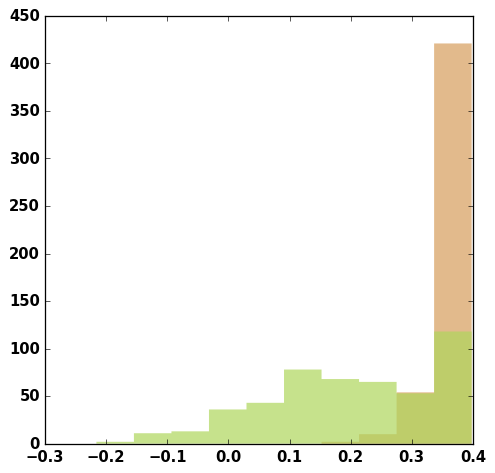

In [276]:
hist([avneg["log_Z_L_mod"], c2tab["log_Z_L_mod"]], histtype="stepfilled", alpha=0.7)

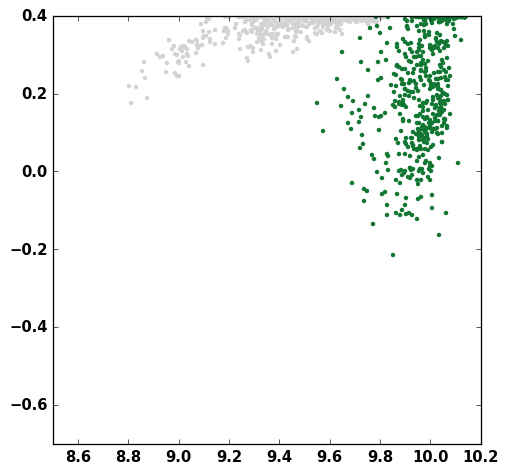

In [277]:
xlim(8.5, 10.2)
ylim(-0.7, 0.4)

plot(c2tab["log_t_L_mod"], c2tab["log_Z_L_mod"], ".", color="lightgray")
plot(avneg["log_t_L_mod"], avneg["log_Z_L_mod"], ".", color=colors[1])